## Example of Common Effects

Here we investigate the direct influence of the Indian Ocean Dipole (IOD) on precipitaion over Australia (AU) in early summer (OND). 

Both ENSO and the IOD are key drivers of Australian climate and their influence on precipitation is well documented. Also the timing of the stratospheric polar vortex breakdown (SPV), which is also influenced by ENSO, is known to affect precipitation in Australia by altering the jet position. We further assume that ENSO affects the IOD, as suggested by several studies. More provisionally, we also assume the IOD to affect Vortex. 

We illustrate how to disentangle the various pathways contributing to Australian precipitation in order to isolate the direct effect of IOD.

<img src="../images/extra_common_effects.png" width="500" height="600">

## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import iris
import iris.quickplot as qplt

import statsmodels.api as sm
from scipy import signal
from scipy.stats import pearsonr

### Step 1) Load the data + plot the time-series

In [2]:
# data from 1950 to 2019, year 2002 was removed because it is the only SH Sudden Stratospheric Warming on record.
au     = iris.load_cube('../sample_data/precip_AU_ond_no2002.nc')
enso   = iris.load_cube('../sample_data/enso_full_ond_no2002.nc')
iod    = iris.load_cube('../sample_data/iod_ond_no2002.nc') 
spv = iris.load_cube('../sample_data/vortex_breakdown_no2002.nc') #'breakdown date in days after 1st Oct' )

#### Plot the data

/envs/auto-build-envs/datasci/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


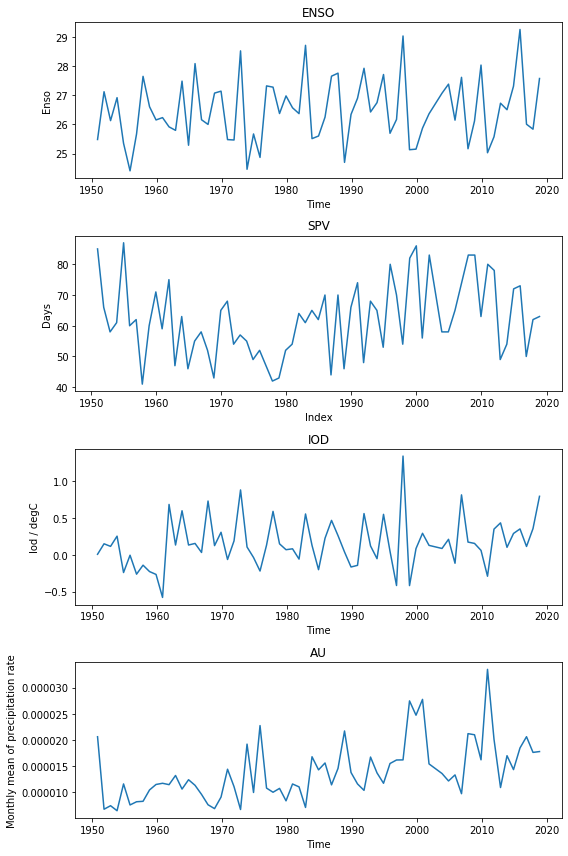

In [3]:
fig = plt.figure(figsize=(8, 12))

plt.subplot(411)
qplt.plot(enso)
plt.title('ENSO')

plt.subplot(412)
qplt.plot(spv)
plt.title('SPV')
plt.tight_layout()

plt.subplot(413)
qplt.plot(iod)
plt.title('IOD')

plt.subplot(414)
qplt.plot(au)
plt.title('AU')
plt.tight_layout()

### Step 2)   Data Processing

#### Standardize the data (zero mean, unit variance)

In [4]:
ENSO   = (enso - np.mean(enso.data))/np.std(enso.data)
SPV = (spv - np.mean(spv.data))/np.std(spv.data)
AU     = (au - np.mean(au.data))/np.std(au.data)
IOD    = (iod - np.mean(iod.data))/np.std(iod.data)


#### Detrend

In [5]:
ENSO   = signal.detrend(ENSO.data)
SPV = signal.detrend(SPV.data)
AU     = signal.detrend(AU.data)
IOD    = signal.detrend(IOD.data)

### Step 3)   Data Analysis

We are interested in quantifying the direct, tropospheric influence of IOD on AU.
First, we do this 'naively' by controlling for Vortex only.

In [6]:
Y = AU[:]
X = np.stack([IOD, SPV]).T

model = sm.OLS(Y,X)
results = model.fit()


print("AU = %.2f IOD + %.2f SPV \n"%(results.params[0],results.params[1]))
print("effect of IOD on AU (ENSO uncontrolled) : %.2f \n "%results.params[0])

AU = -0.26 IOD + 0.25 SPV 

effect of IOD on AU (ENSO uncontrolled) : -0.26 
 


In the previous regression there are two different types of biases: 

- The first one is a common driver bias (as in Example 1) introduced by ENSO which influences both IOD and AU directly (note that the other indirect path from ENSO to AU via SPV is already blocked since we controlled for its mediator SPV). 

- The second type of bias results from conditioning on SPV. SPV is a common effect (or collider) of ENSO and IOD and controlling for it introduces a non-causal association between them (in addition to their dependence due to the assumed direct, causal influence of ENSO on IOD). Thus, there is an open path from IOD (via the opened collider SPV) to ENSO and further to AU, biasing the analysis of the direct, causal effect of IOD on AU.

To overcome both types of biases, we here simply have to block the influence of ENSO, i.e., we also need to include ENSO in the regression:

In [7]:
Y = AU[:]
X = np.stack([IOD, SPV, ENSO]).T

model = sm.OLS(Y,X)
results_causal = model.fit()

print("AU = %.2f IOD + %.2f SPV + %.2f ENSO  \n"\
      %(results_causal.params[0],results_causal.params[1],results_causal.params[2]))

print("causal effect of IOD on AU : %.2f "%results_causal.params[0])

AU = -0.05 IOD + 0.19 SPV + -0.43 ENSO  

causal effect of IOD on AU : -0.05 


### Conclusions
To estimate the direct, tropospheric influence of IOD on AU, controling for SPV is not enough as this will lead to a biased estimate due to 1) the common driver ENSO and 2) because controlling for SPV opens a path from IOD to ENSO and then to AU, introducinga spurious statistical association. Including ENSO in the regression allows to account for both biases. 

Overall, caution is needed when controlling for another process. While conditioning on a third variable is necessary to block the effect of a common driver or an indirect pathway, it can lead to confusion and bias if done for a common effect.